In [15]:
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
%matplotlib inline
WORK_DIR = './'
%config InlineBackend.figure_format = 'svg'
AUTH_TOKEN = 'c52b7825851b4357af3e06c1888152f0'
TEAMS_URL = 'http://api.football-data.org/v1/soccerseasons/439/teams'
from scipy.cluster.vq import whiten, kmeans2


In [7]:
def request_data(uri, extract_data):
    json = {}
    try:
        json = requests.get(uri, headers = { 'X-Auth-Token': AUTH_TOKEN }).json()
        return json[extract_data]
    except:
        return None 

In [51]:
teams = request_data(TEAMS_URL, 'teams')
for item in teams:
    players = request_data(item['_links']['players']['href'], 'players') #BOOM, market value lost... hmm
    fixtures = request_data(item['_links']['fixtures']['href'], 'fixtures')
    fails = 0
    for f in fixtures:
        if item['name'] == f['homeTeamName']:
            fails += f['result']['goalsHomeTeam'] if f['result']['goalsAwayTeam'] else 0
        else:
            fails += f['result']['goalsAwayTeam'] if f['result']['goalsHomeTeam'] else 0
    strarts_with_d = 0
    for pname in players:
        if pname['name'].startswith('D'):
            strarts_with_d += 1
    item['players'] = players
    item['fails'] = fails
    item['s_with_d'] = strarts_with_d
    print('Club name "{}", {} players, {} fails, Names with D {}'.format(item['name'], len(players), 
            fails, item['s_with_d']))

Club name "FC Rio Ave", 30 players, 25 fails, Names with D 0
Club name "FC Porto", 21 players, 33 fails, Names with D 2
Club name "Moreirense FC", 28 players, 26 fails, Names with D 3
Club name "FC Paços de Ferreira", 30 players, 29 fails, Names with D 0
Club name "Sporting CP", 26 players, 46 fails, Names with D 2
Club name "Maritimo Funchal", 30 players, 21 fails, Names with D 3
Club name "CD Tondela", 26 players, 23 fails, Names with D 2
Club name "SL Benfica", 26 players, 32 fails, Names with D 0
Club name "Boavista Porto FC", 29 players, 20 fails, Names with D 1
Club name "FC Arouca", 27 players, 25 fails, Names with D 0
Club name "Vitoria Setubal", 26 players, 17 fails, Names with D 1
Club name "C.F. Os Belenenses", 25 players, 22 fails, Names with D 3
Club name "Vitoria Guimaraes", 24 players, 32 fails, Names with D 2
Club name "Sporting Braga", 27 players, 35 fails, Names with D 1
Club name "GD Estoril Praia", 29 players, 26 fails, Names with D 3
Club name "Feirense", 0 players

In [52]:
pandas_data = []
for item in teams:
    if item['players']:
        pandas_data.append({'name': item['name'], 'players': len(item['players']), 
                            'fails': item['fails'], 's_with_d':item['s_with_d']})
pandas_data

[{'fails': 25, 'name': 'FC Rio Ave', 'players': 30, 's_with_d': 0},
 {'fails': 33, 'name': 'FC Porto', 'players': 21, 's_with_d': 2},
 {'fails': 26, 'name': 'Moreirense FC', 'players': 28, 's_with_d': 3},
 {'fails': 29, 'name': 'FC Paços de Ferreira', 'players': 30, 's_with_d': 0},
 {'fails': 46, 'name': 'Sporting CP', 'players': 26, 's_with_d': 2},
 {'fails': 21, 'name': 'Maritimo Funchal', 'players': 30, 's_with_d': 3},
 {'fails': 23, 'name': 'CD Tondela', 'players': 26, 's_with_d': 2},
 {'fails': 32, 'name': 'SL Benfica', 'players': 26, 's_with_d': 0},
 {'fails': 20, 'name': 'Boavista Porto FC', 'players': 29, 's_with_d': 1},
 {'fails': 25, 'name': 'FC Arouca', 'players': 27, 's_with_d': 0},
 {'fails': 17, 'name': 'Vitoria Setubal', 'players': 26, 's_with_d': 1},
 {'fails': 22, 'name': 'C.F. Os Belenenses', 'players': 25, 's_with_d': 3},
 {'fails': 32, 'name': 'Vitoria Guimaraes', 'players': 24, 's_with_d': 2},
 {'fails': 35, 'name': 'Sporting Braga', 'players': 27, 's_with_d': 1},


In [53]:
teams_pd = pd.DataFrame(pandas_data)
teams_pd

,fails,name,players,s_with_d
0,25,FC Rio Ave,30,0
1,33,FC Porto,21,2
2,26,Moreirense FC,28,3
3,29,FC Paços de Ferreira,30,0
4,46,Sporting CP,26,2
5,21,Maritimo Funchal,30,3
6,23,CD Tondela,26,2
7,32,SL Benfica,26,0
8,20,Boavista Porto FC,29,1
9,25,FC Arouca,27,0


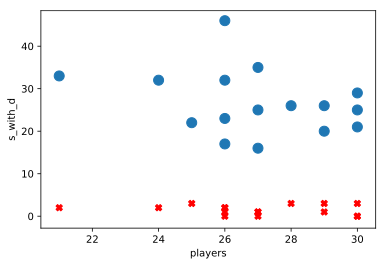

In [59]:
ax = teams_pd.plot.scatter(x='players', y='fails', s=100)
teams_pd.plot.scatter(ax=ax, x='players', y='s_with_d', s=40, marker='X', c='r' )
#plot.scatter(x='players', y='s_with_d', s=100)

In [66]:
plan_a = teams_pd[['fails','players']]
plan_b = teams_pd[['fails','s_with_d']]
whitened_a = whiten(plan_a.as_matrix())
whitened_b = whiten(plan_b.as_matrix())
whitened_b

array([[ 3.38837074,  0.        ],
       [ 4.47264937,  1.78885438],
       [ 3.52390557,  2.68328157],
       [ 3.93051006,  0.        ],
       [ 6.23460216,  1.78885438],
       [ 2.84623142,  2.68328157],
       [ 3.11730108,  1.78885438],
       [ 4.33711454,  0.        ],
       [ 2.71069659,  0.89442719],
       [ 3.38837074,  0.        ],
       [ 2.3040921 ,  0.89442719],
       [ 2.98176625,  2.68328157],
       [ 4.33711454,  1.78885438],
       [ 4.74371903,  0.89442719],
       [ 3.52390557,  2.68328157],
       [ 2.16855727,  0.89442719]])

In [67]:
centroids_a, cluster_map_a = kmeans2(whitened_a, 3)
centroids_a, cluster_map_a

(array([[  4.82503993,  10.51887304],
        [  3.32060332,  12.44167779],
        [  2.79201749,  11.11268039]]),
 array([1, 0, 1, 1, 0, 1, 2, 0, 1, 2, 2, 2, 0, 0, 1, 2]))

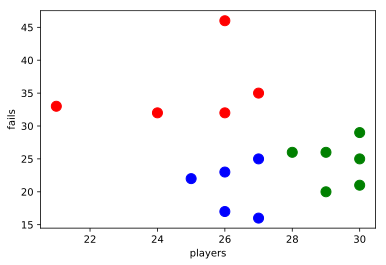

In [70]:
colors_map = {0: 'r', 1: 'g', 2: 'b', 3: 'y', 4: 'm'}
colors = [colors_map[c] for c in cluster_map_a]
plan_a.plot.scatter(x='players', y='fails', c=colors, s=100)

In [72]:
centroids_a, cluster_map_a = kmeans2(whitened_a, 5)
centroids_a, cluster_map_a

(array([[  2.23632469,  11.23992482],
        [  3.19862198,  12.38512471],
        [  3.16247936,  11.02785077],
        [  4.84537016,  10.28559158],
        [  4.33711454,  12.08822104]]),
 array([1, 3, 1, 4, 3, 1, 2, 3, 1, 2, 0, 2, 3, 4, 1, 0]))

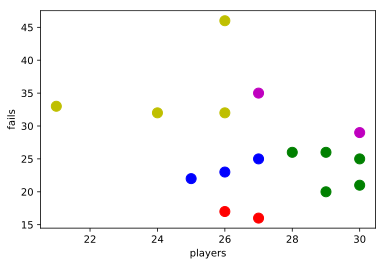

In [73]:
colors_map = {0: 'r', 1: 'g', 2: 'b', 3: 'y', 4: 'm'}
colors = [colors_map[c] for c in cluster_map_a]
plan_a.plot.scatter(x='players', y='fails', c=colors, s=100)

In [75]:
centroids_b, cluster_map_b = kmeans2(whitened_b, 3)
centroids_b, cluster_map_b

(array([[ 4.33711454,  0.2981424 ],
        [ 3.87968449,  2.23606798],
        [ 2.79201749,  0.53665631]]),
 array([2, 1, 1, 0, 1, 1, 1, 0, 2, 2, 2, 1, 1, 0, 1, 2]))

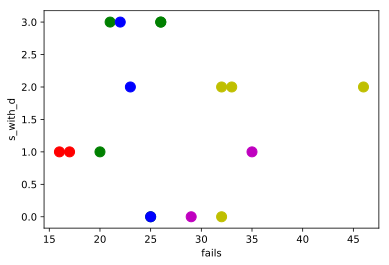

In [77]:
colors_map = {0: 'r', 1: 'g', 2: 'b', 3: 'y', 4: 'm'}
colors = [colors_map[c] for c in cluster_map_a]
plan_b.plot.scatter(x='fails', y='s_with_d', c=colors, s=100)

In [78]:
centroids_b, cluster_map_b = kmeans2(whitened_b, 5)
centroids_b, cluster_map_b

(array([[ 2.39444865,  0.89442719],
        [ 6.23460216,  1.78885438],
        [ 3.19862198,  2.50439613],
        [ 4.51782765,  1.49071198],
        [ 3.76109152,  0.        ]]),
 array([4, 3, 2, 4, 1, 2, 2, 4, 0, 4, 0, 2, 3, 3, 2, 0]))

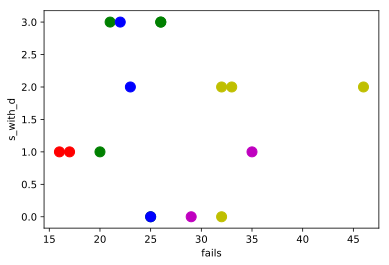

In [79]:
colors_map = {0: 'r', 1: 'g', 2: 'b', 3: 'y', 4: 'm'}
colors = [colors_map[c] for c in cluster_map_a]
plan_b.plot.scatter(x='fails', y='s_with_d', c=colors, s=100)